In [25]:
import pandas as pd
import numpy as np
import psycopg2
import math
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as scs
import scipy
import itertools
sns.set(font_scale=1.5)

In [2]:
#Create connection and cursor
conn = psycopg2.connect("dbname=pfxbaseballdata")
cur = conn.cursor()

In [3]:
# Define query
query = """
SELECT DISTINCT(fgd.play_guid)
, bst.games             
, bst.plate_apps        
, bst.ab                
, bst.h                 
, bst.b1                  
, bst.b2                
, bst.b3                
, bst.hr               
, bst.r             
, bst.rbi                 
, bst.bb               
, bst.ibb       
, bst.so                
, bst.hbp         
, bst.sf            
, bst.sh               
, bst.gdp               
, bst.sb                  
, bst.cs                 
, bst.ba_avg        
, bst.bb_percent        
, bst.k_percent        
, bst.bb_to_k                       
, bst.obp                
, bst.slg                
, bst.ops                 
, bst.iso                 
, bst.babip              
, bst.w_rc                
, bst.w_raa               
, bst.w_oba               
, bst.wrc_plus            
, bst.gb_to_fb 
, bst.ld_percent        
, bst.gb_percent       
, bst.fb_percent        
, bst.iffb_percent    
, bst.hr_to_fb             
, bst.pull_percent     
, bst.center_percent   
, bst.oppo_percent       
, bst.soft_percent      
, bst.med_percent   
, bst.hard_percent
, bst.playerid
, fgd.batter_id
, fgd.ab_id
, fgd.des
, fgd.stand
, fgd.strikes
, fgd.balls
, fgd.p_throws
, fgd.gid
, fgd.pdes
, fgd.inning
, pst.wins
, pst.losses
, pst.saves
, pst.games
, pst.games_started
, pst.innings_pitched
, pst.k_per_9
, pst.bb_per_9 
, pst.hr_per_9
, pst.babip
, pst.lob_percent
, pst.gb_percent
, pst.hr_to_fb
, pst.era
, pst.fip
, pst.xfip
, pst.war
, pst.playerid  
FROM fg_game_data AS fgd
INNER JOIN pitcher_stats_table AS pst ON fgd.pitcher_fg_id = pst.playerid
INNER JOIN batter_stats_table AS bst ON fgd.batter_fg_id = bst.playerid
;
"""
#Execute the query
cur.execute(query)
# Return the next row
GameData = cur.fetchall()

In [4]:
GameData_df = pd.DataFrame(GameData, columns=["play_guid", "batter_games", "batter_plate_apps", "batter_ab", "batter_h"
                                              ,"batter_1b", "batter_2b", "batter_3b", "batter_hr", "batter_r", "batter_rbi"                 
                                              ,"batter_bb", "batter_ibb", "batter_so", "batter_hbp", "bater_sf", "batter_sh"
                                              ,"batter_gdp", "batter_sb", "batter_cs", "batter_avg", "batter_bb_percent"
                                              ,"batrer_k_percent", "batter_bb_to_k", "batter_obp", "batter_slg", "batter_ops"
                                              ,"batter_iso", "batter_babip", "batter_w_rc", "batter_w_raa", "batter_w_oba"
                                              ,"batter_wrc_plus", "batter_gb_to_fb", "batter_ld_percent", "batter_gb_percent"
                                              ,"batter_fb_percent", "batter_iffb_percent", "batter_hr_to_fb", "batter_pull_percent"
                                              ,"batter_center_percent", "batter_oppo_percent", "batter_soft_percent"
                                              ,"batter_med_percent", "batter_hard_percent", "batter_playerid", "mlb_batter_id"
                                              ,"ab_id", "des", "stand", "strikes", "balls", "p_throws", "gid", "pdes"
                                              ,"inning", "pitcher_wins", "pitcher_losses", "pitcher_saves", "pitcher_games"
                                              ,"pitcher_games_started", "pitcher_innings_pitched", "pitcher_k_per_9"
                                              ,"pitcher_bb_per_9", "pitcher_hr_per_9", "pitcher_babip", "pitcher_lob_percent"
                                              ,"pitcher_gb_percent", "pitcher_hr_to_fb", "pitcher_era", "pitcher_fip"
                                              ,"pitcher_xfip", "pitcher_war", "pitcher_playerid"])

cleanGameData_df = GameData_df

In [5]:
#convert right vs left hander batter to binary
batter_stance = []
for batter in GameData_df.loc[:,]['stand']:
    if batter == 'R':
        batter_stance.append(1)
    else:
        batter_stance.append(0)
cleanGameData_df['batter_stance'] = batter_stance

In [6]:
#convert right vs left hander pitcher to binary
right_left_handness = []
for pitcher in GameData_df.loc[:,]['p_throws']:
    if pitcher == 'R':
        right_left_handness.append(1)
    else:
        right_left_handness.append(0)
cleanGameData_df['pitcher_handedness'] = right_left_handness

In [132]:
#Convert probabilities within data set to log odds for logistic regression analysis
#Log Odds: LO = LOGe[Odds]= LOGe[p/(1-p)] 
def proba_to_logodds(probability):
    odds = (probability / (1 - probability))
    logodds = math.log(odds)
    return logodds
#test    
proba_to_logodds(.2)

-1.3862943611198906

In [133]:
#Columns to convert to logodds
columns_to_convert = ["batter_bb_percent", "batter_k_percent", "batter_avg", "batter_obp", "batter_slg" 
                      ,"pitcher_lob_percent","pitcher_gb_percent", "pitcher_hr_fb_percent", "batter_ld_percent"
                      , "batter_gb_percent","batter_fb_percent", "batter_iffb_percent"]
labels = ["BB_logodds", "K_logodds", "BA_AVG_logodds", "b_OBP_logodds", "b_SLG_logodds", "p_lob_logodds"
          ,"p_gb_logodds", "p_hr_fb_logodds", "batter_ld_logodds", "batter_gb_logodds", "batter_fb_logodds"
          , "batter_iffb_logodds"]

In [134]:
def convert_to_logodds(list_DFs, labels):
    for idx, DF in enumerate(list_DFs):
        temp_lst = []
        for i in GameData_df.iloc[:,][DF]:
            temp_lst.append(proba_to_logodds(i))
        cleanGameData_df[labels[idx]] = temp_lst
        
convert_to_logodds(columns_to_convert, labels)

ValueError: math domain error

In [ ]:
def log5_method(x, y, z=.255):
    log5_metric = []
    log5_answer = ((x * y) / z) / ((x * y) / z) + ((1 - x) * (1 - y) / (1 - z))
    log5_metric.append(log5_answer)

In [ ]:
for index, row in GameData_df.iterrows():
    log5_method(GameData_df['b_ba_avg'], GameData_df[''])

In [181]:
gid_ab_dct = dict()
ab_ids = []
test_GameData = pd.DataFrame
for idx, row in GameData_df.iterrows():
    if row['game_id'] in gid_ab_dct.keys() and row['ab_id'] in gid_ab_dct[row['game_id']]:
        continue
    elif row['game_id'] in gid_ab_dct.keys() and row['ab_id'] not in gid_ab_dct[row['game_id']]:
        ab_ids.append(row['ab_id'])
        gid_ab_dct[row['game_id']] = ab_ids
        test_GameData.append((pd.Series.to_frame(row)))
    elif row['game_id'] not in gid_ab_dct.keys():
        ab_ids.append(row['ab_id'])
        gid_ab_dct[row['game_id']] = ab_ids
        test_GameData.append((pd.Series.to_frame(row)))
    else:
        continue

TypeError: append() missing 1 required positional argument: 'other'

In [7]:
#AB_outcome predictions
cleanGameData_df = cleanGameData_df.drop(columns=["play_guid", "p_throws", "stand","batter_playerid"
                                                  ,"mlb_batter_id",'pitcher_playerid', 'strikes', 'balls', 'pdes','gid'
                                                  ,"batter_1b", "batter_2b", "batter_3b", "batter_hr", "batter_r", "batter_rbi"                 
                                                  ,"batter_bb", "batter_ibb","batter_iso", "batter_babip", "batter_w_rc", "batter_w_raa", "batter_w_oba"
                                                  ,"batter_wrc_plus", "batter_gb_to_fb", "batter_ld_percent", "batter_gb_percent"
                                                  ,"batter_fb_percent", "batter_iffb_percent", "batter_hr_to_fb", "batter_pull_percent"
                                                  ,"batter_center_percent", "batter_oppo_percent", "batter_soft_percent"
                                                  ,"batter_med_percent", "batter_hard_percent","pitcher_hr_per_9", "pitcher_babip", "pitcher_lob_percent"
                                                  ,"pitcher_gb_percent", "pitcher_hr_to_fb"])


In [8]:
cleanGameData_df

,batter_games,batter_plate_apps,batter_ab,batter_h,batter_so,batter_hbp,bater_sf,batter_sh,batter_gdp,batter_sb,...,pitcher_games_started,pitcher_innings_pitched,pitcher_k_per_9,pitcher_bb_per_9,pitcher_era,pitcher_fip,pitcher_xfip,pitcher_war,batter_stance,pitcher_handedness
0,105,398,353,84,89,6,2,0,4,4,...,116,714.2,7.96,3.98,3.84,4.73,4.90,3.5,0,0
1,142,530,480,116,133,3,4,0,10,5,...,56,361.2,7.34,2.19,3.91,3.38,3.32,7.1,0,1
2,98,300,261,49,73,3,1,0,4,2,...,75,436.0,7.29,3.61,4.38,4.44,4.38,3.8,0,1
3,5,15,14,5,4,1,0,0,0,0,...,159,918.2,7.86,3.33,4.20,4.08,4.14,11.1,1,0
4,117,453,411,95,136,5,0,3,11,18,...,52,306.1,5.55,2.50,4.08,4.43,4.31,2.3,1,1
5,115,467,427,93,104,5,6,0,12,4,...,0,322.0,6.43,2.12,3.91,3.80,3.50,0.9,1,1
6,48,210,178,43,46,7,0,0,1,6,...,183,1135.0,6.50,1.93,4.13,3.76,3.74,17.4,0,1
7,98,337,299,83,39,3,1,8,4,30,...,109,672.0,7.47,3.01,3.82,3.76,3.82,7.9,0,1
8,157,624,584,141,136,3,4,8,16,16,...,0,330.1,8.64,2.37,3.27,3.24,3.48,4.1,0,1
9,90,321,280,74,56,0,3,0,8,0,...,130,821.1,7.77,2.40,3.39,3.85,3.97,10.0,0,1


In [9]:
cleanGameData_df = cleanGameData_df.drop_duplicates()
cleanGameData_df

,batter_games,batter_plate_apps,batter_ab,batter_h,batter_so,batter_hbp,bater_sf,batter_sh,batter_gdp,batter_sb,...,pitcher_games_started,pitcher_innings_pitched,pitcher_k_per_9,pitcher_bb_per_9,pitcher_era,pitcher_fip,pitcher_xfip,pitcher_war,batter_stance,pitcher_handedness
0,105,398,353,84,89,6,2,0,4,4,...,116,714.2,7.96,3.98,3.84,4.73,4.90,3.5,0,0
1,142,530,480,116,133,3,4,0,10,5,...,56,361.2,7.34,2.19,3.91,3.38,3.32,7.1,0,1
2,98,300,261,49,73,3,1,0,4,2,...,75,436.0,7.29,3.61,4.38,4.44,4.38,3.8,0,1
3,5,15,14,5,4,1,0,0,0,0,...,159,918.2,7.86,3.33,4.20,4.08,4.14,11.1,1,0
4,117,453,411,95,136,5,0,3,11,18,...,52,306.1,5.55,2.50,4.08,4.43,4.31,2.3,1,1
5,115,467,427,93,104,5,6,0,12,4,...,0,322.0,6.43,2.12,3.91,3.80,3.50,0.9,1,1
6,48,210,178,43,46,7,0,0,1,6,...,183,1135.0,6.50,1.93,4.13,3.76,3.74,17.4,0,1
7,98,337,299,83,39,3,1,8,4,30,...,109,672.0,7.47,3.01,3.82,3.76,3.82,7.9,0,1
8,157,624,584,141,136,3,4,8,16,16,...,0,330.1,8.64,2.37,3.27,3.24,3.48,4.1,0,1
9,90,321,280,74,56,0,3,0,8,0,...,130,821.1,7.77,2.40,3.39,3.85,3.97,10.0,0,1


In [10]:
#Single Pitch Outcome
cleanGameData_df = cleanGameData_df.drop(columns=["play_guid","b_bb_percent", "b_k_percent", 
                                                  "b_ba_avg","b_obp", "b_slg", "p_lob_percent",
                                                  "p_gb_percent", "p_hr_fb_percent","outcome",
                                                  "p_throws","stand", "pitch_outcome"])

In [10]:
#Binary Outcome for logistic regression
ab_outcome = [] 
ball_in_play = ['Single', 'Double', 'Triple', 'Home Run']
for pitch in cleanGameData_df.loc[:,('des')]:
    if pitch in ball_in_play:
        ab_outcome.append(1)
    else:
        ab_outcome.append(0)
cleanGameData_df['ab_outcome'] = ab_outcome

/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [11]:
cleanGameData_df = cleanGameData_df.drop(columns=["des"])

In [11]:
#Onyl run for pitch outcome!!!

#Binary Outcome for logistic regression
outcome = [] 
for pitch in GameData_df.loc[:,]['pitch_outcome']:
    if 'play' in pitch:
        if 'no' in pitch or 'run' in pitch:
            outcome.append(1) #1 indicates hit
        else:
            outcome.append(0)
    else:
        outcome.append(0) #0 indicates a non-hit outcome
cleanGameData_df['pitch_outcome'] = outcome

In [302]:
cleanGameData_df = cleanGameData_df.drop(columns=['outcome'])

In [42]:
cleanGameData_df.loc[cleanGameData_df.isnull():,]

TypeError: '       batter_games  batter_plate_apps  batter_ab  batter_h  batter_1b  \
0             False              False      False     False      False   
1             False              False      False     False      False   
2             False              False      False     False      False   
3             False              False      False     False      False   
4             False              False      False     False      False   
5             False              False      False     False      False   
6             False              False      False     False      False   
7             False              False      False     False      False   
8             False              False      False     False      False   
9             False              False      False     False      False   
10            False              False      False     False      False   
11            False              False      False     False      False   
12            False              False      False     False      False   
13            False              False      False     False      False   
14            False              False      False     False      False   
15            False              False      False     False      False   
16            False              False      False     False      False   
17            False              False      False     False      False   
18            False              False      False     False      False   
19            False              False      False     False      False   
21            False              False      False     False      False   
22            False              False      False     False      False   
23            False              False      False     False      False   
24            False              False      False     False      False   
25            False              False      False     False      False   
26            False              False      False     False      False   
27            False              False      False     False      False   
28            False              False      False     False      False   
29            False              False      False     False      False   
30            False              False      False     False      False   
...             ...                ...        ...       ...        ...   
33327         False              False      False     False      False   
33336         False              False      False     False      False   
33405         False              False      False     False      False   
33407         False              False      False     False      False   
33423         False              False      False     False      False   
33513         False              False      False     False      False   
33515         False              False      False     False      False   
33565         False              False      False     False      False   
33606         False              False      False     False      False   
33672         False              False      False     False      False   
33888         False              False      False     False      False   
33895         False              False      False     False      False   
33916         False              False      False     False      False   
33997         False              False      False     False      False   
34033         False              False      False     False      False   
34050         False              False      False     False      False   
34110         False              False      False     False      False   
34113         False              False      False     False      False   
34179         False              False      False     False      False   
34216         False              False      False     False      False   
34308         False              False      False     False      False   
34339         False              False      False     False      False   
34351         False              False      False     False      False   
34361         False              False      False     False      False   
34372         False              False      False     False      False   
34473         False              False      False     False      False   
34498         False              False      False     False      False   
34507         False              False      False     False      False   
34511         False              False      False     False      False   
34539         False              False      False     False      False   

       batter_2b  batter_3b  batter_hr  batter_r  batter_rbi     ...      \
0          False      False      False     False       False     ...       
1          False      False      False     False       False     ...       
2          False      False      False     False       False     ...       
3          False      False      False     False       False     ...       
4          False      False      False     False       False     ...       
5          False      False      False     False       False     ...       
6          False      False      False     False       False     ...       
7          False      False      False     False       False     ...       
8          False      False      False     False       False     ...       
9          False      False      False     False       False     ...       
10         False      False      False     False       False     ...       
11         False      False      False     False       False     ...       
12         False      False      False     False       False     ...       
13         False      False      False     False       False     ...       
14         False      False      False     False       False     ...       
15         False      False      False     False       False     ...       
16         False      False      False     False       False     ...       
17         False      False      False     False       False     ...       
18         False      False      False     False       False     ...       
19         False      False      False     False       False     ...       
21         False      False      False     False       False     ...       
22         False      False      False     False       False     ...       
23         False      False      False     False       False     ...       
24         False      False      False     False       False     ...       
25         False      False      False     False       False     ...       
26         False      False      False     False       False     ...       
27         False      False      False     False       False     ...       
28         False      False      False     False       False     ...       
29         False      False      False     False       False     ...       
30         False      False      False     False       False     ...       
...          ...        ...        ...       ...         ...     ...       
33327      False      False      False     False       False     ...       
33336      False      False      False     False       False     ...       
33405      False      False      False     False       False     ...       
33407      False      False      False     False       False     ...       
33423      False      False      False     False       False     ...       
33513      False      False      False     False       False     ...       
33515      False      False      False     False       False     ...       
33565      False      False      False     False       False     ...       
33606      False      False      False     False       False     ...       
33672      False      False      False     False       False     ...       
33888      False      False      False     False       False     ...       
33895      False      False      False     False       False     ...       
33916      False      False      False     False       False     ...       
33997      False      False      False     False       False     ...       
34033      False      False      False     False       False     ...       
34050      False      False      False     False       False     ...       
34110      False      False      False     False       False     ...       
34113      False      False      False     False       False     ...       
34179      False      False      False     False       False     ...       
34216      False      False      False     False       False     ...       
34308      False      False      False     False       False     ...       
34339      False      False      False     False       False     ...       
34351      False      False      False     False       False     ...       
34361      False      False      False     False       False     ...       
34372      False      False      False     False       False     ...       
34473      False      False      False     False       False     ...       
34498      False      False      False     False       False     ...       
34507      False      False      False     False       False     ...       
34511      False      False      False     False       False     ...       
34539      False      False      False     False       False     ...       

       pitcher_lob_percent  pitcher_gb_percent  pitcher_hr_to_fb  pitcher_era  \
0                    False               False             False        False   
1                    False               False             False        False   
2                    False               False             False        False   
3                    False               False             False        False   
4                    False               False             False        False   
5                    False               False             False        False   
6                    False               False             False        False   
7                    False               False             False        False   
8                    False               False             False        False   
9                    False               False             False        False   
10                   False               False             False        False   
11                   False               False             False        False   
12                   False               False             False        False   
13                   False               False             False        False   
14                   False               False             False        False   
15                   False               False             False        False   
16                   False               False             False        False   
17                   False               False             False        False   
18                   False               False             False        False   
19                   False               False             False        False   
21                   False               False             False        False   
22                   False               False             False        False   
23                   False               False             False        False   
24                   False               False             False        False   
25                   False               False             False        False   
26                   False               False             False        False   
27                   False               False             False        False   
28                   False               False             False        False   
29                   False               False             False        False   
30                   False               False             False        False   
...                    ...                 ...               ...          ...   
33327                False               False             False        False   
33336                False               False             False        False   
33405                False               False             False        False   
33407                False               False             False        False   
33423                False               False             False        False   
33513                False               False             False        False   
33515                False               False             False        False   
33565                False               False             False        False   
33606                False               False             False        False   
33672                False               False             False        False   
33888                False               False             False        False   
33895                False               False             False        False   
33916                False               False             False        False   
33997                False               False             False        False   
34033                False               False             False        False   
34050                False               False             False        False   
34110                False               False             False        False   
34113                False               False             False        False   
34179                False               False             False        False   
34216                False               False             False        False   
34308                False               False             False        False   
34339                False               False             False        False   
34351                False               False             False        False   
34361                False               False             False        False   
34372                False               False             False        False   
34473                False               False             False        False   
34498                False               False             False        False   
34507                False               False             False        False   
34511                False               False             False        False   
34539                False               False             False        False   

       pitcher_fip  pitcher_xfip  pitcher_war  batter_stance  \
0            False         False        False          False   
1            False         False        False          False   
2            False         False        False          False   
3            False         False        False          False   
4            False         False        False          False   
5            False         False        False          False   
6            False         False        False          False   
7            False         False        False          False   
8            False         False        False          False   
9            False         False        False          False   
10           False         False        False          False   
11           False         False        False          False   
12           False         False        False          False   
13           False         False        False          False   
14           False         False        False          False   
15           False         False        False          False   
16           False         False        False          False   
17           False         False        False          False   
18           False         False        False          False   
19           False         False        False          False   
21           False         False        False          False   
22           False         False        False          False   
23           False         False        False          False   
24           False         False        False          False   
25           False         False        False          False   
26           False         False        False          False   
27           False         False        False          False   
28           False         False        False          False   
29           False         False        False          False   
30           False         False        False          False   
...            ...           ...          ...            ...   
33327        False         False        False          False   
33336        False         False        False          False   
33405        False         False        False          False   
33407        False         False        False          False   
33423        False         False        False          False   
33513        False         False        False          False   
33515        False         False        False          False   
33565        False         False        False          False   
33606        False         False        False          False   
33672        False         False        False          False   
33888        False         False        False          False   
33895        False         False        False          False   
33916        False         False        False          False   
33997        False         False        False          False   
34033        False         False        False          False   
34050        False         False        False          False   
34110        False         False        False          False   
34113        False         False        False          False   
34179        False         False        False          False   
34216        False         False        False          False   
34308        False         False        False          False   
34339        False         False        False          False   
34351        False         False        False          False   
34361        False         False        False          False   
34372        False         False        False          False   
34473        False         False        False          False   
34498        False         False        False          False   
34507        False         False        False          False   
34511        False         False        False          False   
34539        False         False        False          False   

       pitcher_handedness  ab_outcome  
0                   False       False  
1                   False       False  
2                   False       False  
3                   False       False  
4                   False       False  
5                   False       False  
6                   False       False  
7                   False       False  
8                   False       False  
9                   False       False  
10                  False       False  
11                  False       False  
12                  False       False  
13                  False       False  
14                  False       False  
15                  False       False  
16                  False       False  
17                  False       False  
18                  False       False  
19                  False       False  
21                  False       False  
22                  False       False  
23                  False       False  
24                  False       False  
25                  False       False  
26                  False       False  
27                  False       False  
28                  False       False  
29                  False       False  
30                  False       False  
...                   ...         ...  
33327               False       False  
33336               False       False  
33405               False       False  
33407               False       False  
33423               False       False  
33513               False       False  
33515               False       False  
33565               False       False  
33606               False       False  
33672               False       False  
33888               False       False  
33895               False       False  
33916               False       False  
33997               False       False  
34033               False       False  
34050               False       False  
34110               False       False  
34113               False       False  
34179               False       False  
34216               False       False  
34308               False       False  
34339               False       False  
34351               False       False  
34361               False       False  
34372               False       False  
34473               False       False  
34498               False       False  
34507               False       False  
34511               False       False  
34539               False       False  

[8948 rows x 66 columns]' is an invalid key

In [12]:
null_equals = cleanGameData_df.isnull()

In [47]:
null_arr = null_equals.values

In [49]:
null_arr.shape

(8948, 66)

In [57]:
null_arr.any(axis=1).shape

(8948,)

In [13]:
null_rows = cleanGameData_df.isnull().values.any(axis=1)
non_null_df = cleanGameData_df[~null_rows]

In [30]:
cleanGameData_df.iloc[:,18:20]

,ab_id,inning
0,38,6
1,27,4
2,11,2
3,49,7
4,22,3
5,69,8
6,61,7
7,23,3
8,73,9
9,14,2


In [64]:
# fit a logistic regression model and store the class predictions
logreg = LogisticRegression(C=1e9)
X = np.array(non_null_df.drop(['ab_outcome'], axis=1))
y = np.array(non_null_df['ab_outcome'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=16)
logreg.fit(X_train, y_train)
#hit_proba = logreg.predict_proba(X)
logodds_pred = logreg.predict_log_proba(X_test)
proba_pred = logreg.predict_proba(X_test)
basic_log_score = logreg.score(X_test, y_test)

In [65]:
probabilities = []
for i in proba_pred:
    probabilities.append(i[1])

In [66]:
fpr, tpr, threshold = metrics.roc_curve(y_true=y_test, y_score=proba_pred[:,1])

roc_auc = metrics.roc_auc_score(y_true=y_test, y_score=proba_pred[:,1])
print(roc_auc)

0.5331453654160392


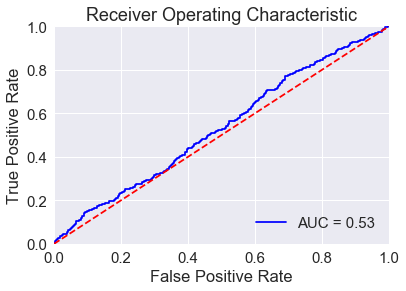

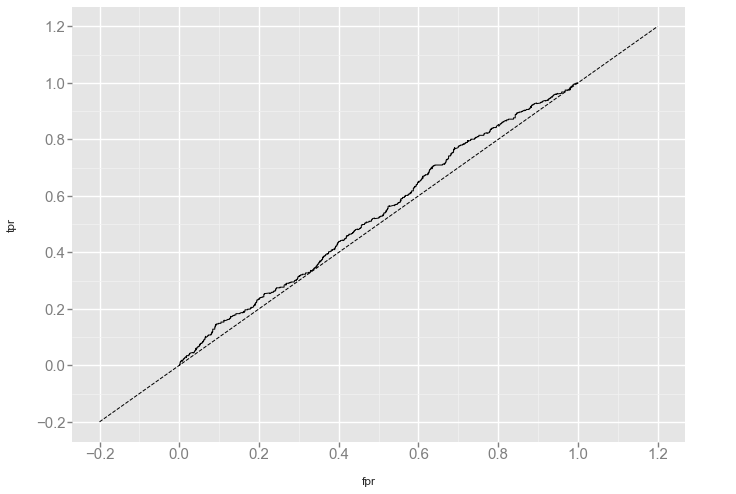

<ggplot: (300044864)>

In [67]:
#ROC PLOT
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# method II: ggplot
from ggplot import *
df = pd.DataFrame(dict(fpr = fpr, tpr = tpr))
ggplot(df, aes(x = 'fpr', y = 'tpr')) + geom_line() + geom_abline(linetype = 'dashed')

Text(0,0.5,'Predicted Pitch Outcome')

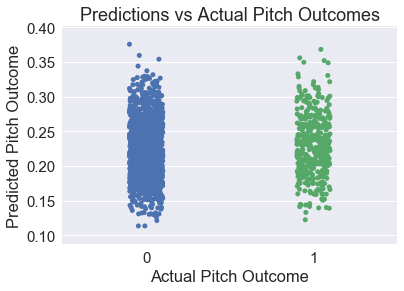

In [19]:
ax = sns.stripplot(x=y_test, y=proba_pred[:,1], jitter=True)
plt.title('Predictions vs Actual Pitch Outcomes')
# Set x-axis label
plt.xlabel('Actual Pitch Outcome')
# Set y-axis label
plt.ylabel('Predicted Pitch Outcome')

In [31]:
# Here we make the plot
roc_plot = plot_partial_dependence(logreg 
                                   ,features=[18, 19] # column numbers of plots we want to show
                                   ,X=X # raw predictors data.
                                   ,feature_names=['ab_id', 'inning'] # labels on graphs
                                   ,grid_resolution=10) # number of values to plot on x axis

ValueError: gbrt has to be an instance of BaseGradientBoosting

In [111]:
logreg.coef_

array([[-0.00571542, -0.00840309,  0.02727825, -0.08129575,  0.02228656,
        -0.00280905, -0.02898839, -0.07178486, -0.00082619, -0.00225098,
        -0.02831171,  0.03822773,  0.00201535, -0.04171503,  0.03572363,
        -0.02096143,  0.01029586, -0.00448414,  0.01896301, -0.00269889,
         0.0003772 , -0.00921546, -0.03489043, -0.00864557, -0.02914513,
        -0.03779069, -0.02644624,  0.05190023,  0.04453563,  0.04552552,
        -0.01742974,  0.00024069, -0.08677799,  0.02600016,  0.02725789,
        -0.11194989, -0.05559022, -0.00816828, -0.03631625, -0.04366379,
        -0.00426428, -0.00177438, -0.08630068,  0.00386638,  0.00730994,
        -0.04758881,  0.00696869,  0.00688064,  0.00102741,  0.00115552,
         0.00821092, -0.00249951, -0.11871617,  0.01327829,  0.16445477,
        -0.02875391, -0.06585801, -0.12529706, -0.01517918, -0.06167156,
        -0.01850635,  0.02769042,  0.02058342, -0.14300363,  0.09375211]])

### Random Forest

In [59]:
#Random Forest Model
'''sklearn.ensemble.RandomForestClassifier(n_estimators=10, criterion=’gini’, max_depth=None, 
                                              min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                                              max_features=’auto’, max_leaf_nodes=None, min_impurity_decrease=0.0, 
                                              min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=1, 
                                              random_state=None, verbose=0, warm_start=False, class_weight=None)
'''
RFC = RandomForestClassifier(random_state=16, n_estimators=10000)
RFC.fit(X_train, y_train)
rf_predict_proba = RFC.predict_proba(X_test)
rf_predictions = RFC.predict(X_test)
tree_split = RFC.decision_path(X_test)
feature_importance = RFC.feature_importances_

In [60]:
feature_importance

array([0.02180395, 0.02257919, 0.02288362, 0.02230177, 0.02369687,
       0.01656037, 0.01499169, 0.0096739 , 0.0193914 , 0.01730468,
       0.01365948, 0.02580958, 0.02477922, 0.02605248, 0.02458476,
       0.02520339, 0.0253388 , 0.02534943, 0.18625773, 0.12751087,
       0.02428731, 0.0240745 , 0.01034509, 0.02597413, 0.02278552,
       0.02498826, 0.02823039, 0.02769908, 0.02717086, 0.02553355,
       0.02694906, 0.02556736, 0.00571309, 0.0049486 ])

In [99]:
(y_test == (rf_predict_proba[:, 1]> 0.7)).mean()

/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  """Entry point for launching an IPython kernel.


AttributeError: 'bool' object has no attribute 'mean'

In [222]:
y_test.mean()

0.22448979591836735

In [62]:
fpr, tpr, threshold = metrics.roc_curve(y_true=y_test, y_score=rf_predict_proba[:,1])

roc_auc = metrics.roc_auc_score(y_true=y_test, y_score=rf_predict_proba[:,1])
print(roc_auc)

0.512126291506537


In [152]:
multinomial_report = metrics.classification_report(y_true=y_test, y_pred=rf_predictions, labels=None, 
                                                   target_names=['Out', 'Hit'], sample_weight=None, digits=2)
multinomial_report

'             precision    recall  f1-score   support\n\n        Out       0.75      0.87      0.81      1357\n        Hit       0.21      0.11      0.14       437\n\navg / total       0.62      0.68      0.64      1794\n'

In [153]:
count = 0
for prediction in rf_predictions:
    if prediction == 1:
        count += 1
    else:
        continue
count

224

In [157]:
updated_threshold = []
for proba in rf_predict_proba[:,1]:
    if proba > 0.25:
        updated_threshold.append(1)
    else:
        updated_threshold.append(0)
sum(updated_threshold)

598

Text(0,0.5,'Predicted Probability Pitch Outcome')

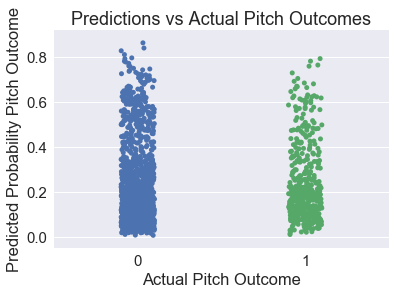

In [159]:
ax = sns.stripplot(x=y_test, y=rf_predict_proba[:,1], jitter=True)
plt.title('Predictions vs Actual Pitch Outcomes')
# Set x-axis label
plt.xlabel('Actual Pitch Outcome')
# Set y-axis label
plt.ylabel('Predicted Probability Pitch Outcome')

### Gradient Boosted

In [35]:
"""sklearn.ensemble.GradientBoostingClassifier(loss=’deviance’, learning_rate=0.1, n_estimators=100, subsample=1.0, 
                                            criterion=’friedman_mse’, min_samples_split=2, min_samples_leaf=1, 
                                            min_weight_fraction_leaf=0.0, max_depth=3, min_impurity_decrease=0.0, 
                                            min_impurity_split=None, init=None, random_state=None, max_features=None
                                            ,verbose=0, max_leaf_nodes=None, warm_start=False, presort=’auto’)"""
GBC = GradientBoostingClassifier(random_state=16, n_estimators=10000)
GBC.fit(X_train, y_train)
gb_predict_proba = GBC.predict_proba(X_test)
gb_predictions = GBC.predict(X_test)
gb_feature_importance = GBC.feature_importances_

In [51]:
gb_feature_importance[18]

0.30550981480700223

In [57]:
fpr, tpr, threshold = metrics.roc_curve(y_true=y_test, y_score=gb_predict_proba[:,1])
roc_auc = metrics.roc_auc_score(y_true=y_test, y_score=gb_predict_proba[:,1])
print(roc_auc)

0.5278115509208123 0.5278115509208123


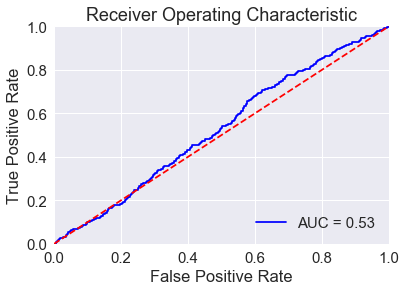

/anaconda/envs/py36/lib/python3.6/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/anaconda/envs/py36/lib/python3.6/site-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
/anaconda/envs/py36/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


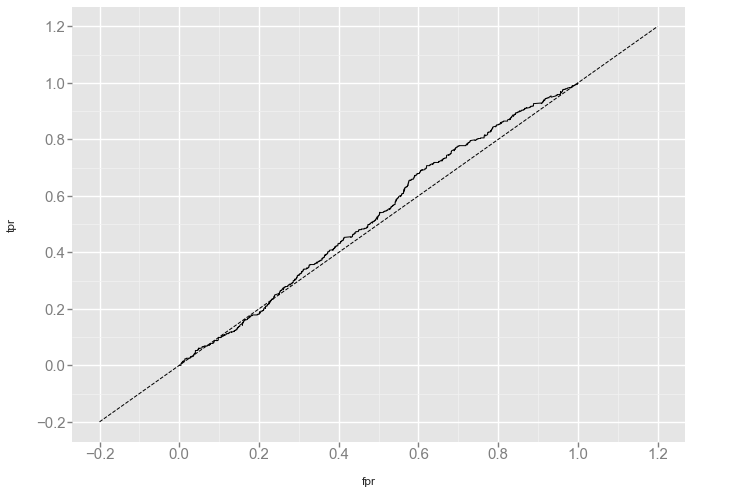

<ggplot: (-9223372036405916626)>

In [58]:

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# method II: ggplot
from ggplot import *
df = pd.DataFrame(dict(fpr = fpr, tpr = tpr))
ggplot(df, aes(x = 'fpr', y = 'tpr')) + geom_line() + geom_abline(linetype = 'dashed')

In [90]:
from __future__ import print_function
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn.ensemble.partial_dependence import partial_dependence


def main():

    names = list(non_null_df.drop(['ab_outcome'], axis=1).columns.values)

    features = [18, 19, (19, 1)]
    fig, axs = plot_partial_dependence(GBC, X_train, features,
                                       feature_names=names,
                                       n_jobs=3, grid_resolution=100)
    fig.suptitle('Partial dependence Inning and AB_ID vs hit')
    plt.subplots_adjust(top=.8)  # tight_layout causes overlap with suptitle

    print('Custom 3d plot via ``partial_dependence``')
    fig = plt.figure()

    target_feature = (18, 20)
    pdp, axes = partial_dependence(GBC, target_feature,
                                   X=X_train, grid_resolution=100)
    XX, YY = np.meshgrid(axes[0], axes[1])
    Z = pdp[0].reshape(list(map(np.size, axes))).T
    ax = Axes3D(fig)
    surf = ax.plot_surface(XX, YY, Z, rstride=1, cstride=1,
                           cmap=plt.cm.BuPu, edgecolor='k')
    ax.set_xlabel(names[target_feature[0]])
    ax.set_ylabel(names[target_feature[1]])
    ax.set_zlabel('Partial dependence')
    #  pretty init view
    ax.view_init(elev=22, azim=122)
    plt.colorbar(surf)
    plt.suptitle('Partial dependence Inning and AB_ID vs hit')
    plt.subplots_adjust(top=0.8)

    plt.show()

sklearn.ensemble.RandomForestClassifier(n_estimators=10, criterion=’gini’, max_depth=None, 
                                              min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                                              max_features=’auto’, max_leaf_nodes=None, min_impurity_decrease=0.0, 
                                              min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=1, 
                                              random_state=None, verbose=0, warm_start=False, class_weight=None)



Custom 3d plot via ``partial_dependence``


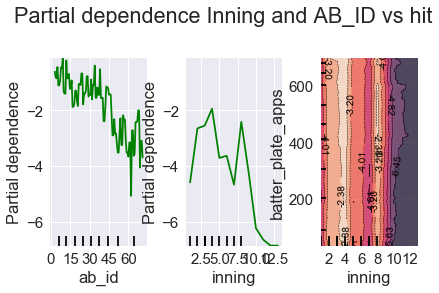

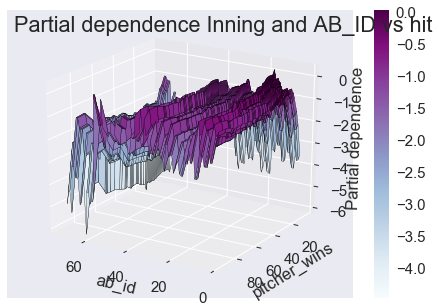

In [91]:
main()

In [75]:
names = list(non_null_df.drop(['ab_outcome'], axis=1).columns.values)

In [76]:
names = list(non_null_df.drop(['ab_outcome'], axis=1).columns.values)

['batter_games',
 'batter_plate_apps',
 'batter_ab',
 'batter_h',
 'batter_so',
 'batter_hbp',
 'bater_sf',
 'batter_sh',
 'batter_gdp',
 'batter_sb',
 'batter_cs',
 'batter_avg',
 'batter_bb_percent',
 'batrer_k_percent',
 'batter_bb_to_k',
 'batter_obp',
 'batter_slg',
 'batter_ops',
 'ab_id',
 'inning',
 'pitcher_wins',
 'pitcher_losses',
 'pitcher_saves',
 'pitcher_games',
 'pitcher_games_started',
 'pitcher_innings_pitched',
 'pitcher_k_per_9',
 'pitcher_bb_per_9',
 'pitcher_era',
 'pitcher_fip',
 'pitcher_xfip',
 'pitcher_war',
 'batter_stance',
 'pitcher_handedness']

## Multinomial Regression
### Out vs. Walk vs. Hit

In [268]:
multinomial_GameData_df = cleanGameData_df

In [267]:
#convert right vs left hander batter to binary
batter_stance = []
for batter in GameData_df.loc[:,]['stand']:
    if batter == 'R':
        batter_stance.append(1)
    else:
        batter_stance.append(0)
multinomial_GameData_df['batter_stance'] = batter_stance

#convert right vs left hander pitcher to binary
right_left_handness = []
for pitcher in GameData_df.loc[:,]['p_throws']:
    if pitcher == 'R':
        right_left_handness.append(1)
    else:
        right_left_handness.append(0)
multinomial_GameData_df['pitcher_handedness'] = right_left_handness

ValueError: Length of values does not match length of index

In [239]:
#Convert probabilities within data set to log odds for logistic regression analysis
#Log Odds: LO = LOGe[Odds]= LOGe[p/(1-p)] 
def proba_to_logodds(probability):
    odds = (probability / (1 - probability))
    logodds = math.log(odds)
    return logodds
#test    
proba_to_logodds(.2)

-1.3862943611198906

In [240]:
#Columns to convert to logodds
columns_to_convert = ["b_bb_percent", "b_k_percent", "b_ba_avg", "b_obp", "b_slg", "p_lob_percent",
                      "p_gb_percent", "p_hr_fb_percent"]
labels = ["BB_logodds", "K_logodds", "BA_AVG_logodds", "b_OBP_logodds", "b_SLG_logodds", 
          "p_lob_logodds","p_gb_logodds", "p_hr_fb_logodds"]

In [241]:
def convert_to_logodds(list_DFs, labels):
    for idx, DF in enumerate(list_DFs):
        temp_lst = []
        for i in GameData_df.iloc[:,][DF]:
            temp_lst.append(proba_to_logodds(i))
        multinomial_GameData_df[labels[idx]] = temp_lst
        
convert_to_logodds(columns_to_convert, labels)

In [242]:
#AB_outcome predictions
multinomial_GameData_df = multinomial_GameData_df.drop(columns=["b_bb_percent", "b_k_percent", "b_ba_avg", "b_obp", "b_slg", "p_lob_percent",
                      "p_gb_percent", "p_hr_fb_percent", "play_guid", "outcome", "p_throws", "stand","b_playerid","b_mlb_id",'p_playerid', 'strikes', 'balls', 'pitch_outcome'])



In [276]:
#Multiclass Outcome for multinomial regression
ab_outcome = [] 
ball_in_play = ['Single', 'Double', 'Triple', 'Home Run']
walk = ['Walk']
for pitch in cleanGameData_df.loc[:,]['outcome']:
    if pitch in ball_in_play:
        ab_outcome.append(2)
    elif pitch in walk:
        ab_outcome.append(1)
    else:
        ab_outcome.append(0)
multinomial_GameData_df['ab_outcome'] = ab_outcome
multinomial_GameData_df = multinomial_GameData_df.drop(columns=['outcome'])

In [277]:
multinomial_GameData_df

,b_games,b_pa,b_hr,b_r,b_rbi,b_sb,b_iso,b_babip,b_wOBA,b_wrc_plus,...,pitcher_handedness,BB_logodds,K_logodds,BA_AVG_logodds,b_OBP_logodds,b_SLG_logodds,p_lob_logodds,p_gb_logodds,p_hr_fb_logodds,ab_outcome
0,688,2720,81,267,294,11,0.157,0.266,0.309,92,...,1,-2.649822,-1.695912,-1.114677,-0.833053,-0.388826,0.828322,0.088057,-2.050519,0
1,365,1313,32,152,112,44,0.167,0.297,0.320,105,...,1,-2.649822,-1.496153,-1.056390,-0.786131,-0.302281,0.842540,0.330989,-1.992430,1
2,1398,6280,133,874,662,134,0.144,0.315,0.355,117,...,1,-2.301486,-2.242481,-0.842540,-0.549416,-0.220894,1.430633,-0.261480,-2.164327,2
3,829,3649,60,449,322,199,0.126,0.334,0.342,118,...,1,-2.824774,-2.153550,-0.795448,-0.601503,-0.253346,1.098612,0.168397,-2.100997,0
4,1173,5069,146,676,566,118,0.172,0.342,0.366,129,...,1,-1.992430,-1.295046,-0.944462,-0.485306,-0.192593,0.929629,0.024001,-1.918759,0
5,295,1117,39,134,136,10,0.197,0.312,0.330,101,...,1,-2.254058,-1.056390,-1.093286,-0.740019,-0.208755,0.772216,-0.447312,-1.857455,2
6,1268,4845,238,637,678,38,0.228,0.305,0.360,123,...,1,-1.955085,-0.999702,-1.087974,-0.610260,-0.080043,1.109308,-0.335101,-1.992430,0
7,779,3353,140,497,507,99,0.227,0.356,0.392,145,...,1,-1.815290,-1.265666,-0.852064,-0.413805,0.100083,0.772216,-0.447312,-1.857455,1
8,1268,4845,238,637,678,38,0.228,0.305,0.360,123,...,0,-1.955085,-0.999702,-1.087974,-0.610260,-0.080043,0.837792,-0.096074,-2.050519,0
9,962,4115,151,483,508,35,0.196,0.269,0.354,124,...,1,-1.695912,-1.557539,-1.114677,-0.553728,-0.224944,1.082676,-0.310470,-2.301486,0


In [278]:
# fit a multinomial regression model and store the class predictions
multi_logreg = LogisticRegression(C=1e12, multi_class='multinomial', solver='lbfgs', max_iter=2000)
X = np.array(multinomial_GameData_df.iloc[:,0:40])
y = np.array(multinomial_GameData_df['ab_outcome'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=16)
multi_logreg.fit(X_train, y_train)
#hit_proba = logreg.predict_proba(X)
multi_logodds_pred = multi_logreg.predict_log_proba(X_test)
multi_proba_pred = multi_logreg.predict_proba(X_test)
multi_basic_log_score = multi_logreg.score(X_test, y_test)
multi_prediction = multi_logreg.predict(X_test)

In [279]:
multinomial_accuracy = metrics.accuracy_score(y_true=y_test, y_pred=multi_prediction, normalize=True, 
                                              sample_weight=None)
multinomial_accuracy

0.6141304347826086

In [280]:
multi_probabilities = []
for i in multi_probabilities:
    multi_probabilities.append(i[1])

In [281]:
multi_proba_pred

array([[8.27766889e-01, 8.05713418e-02, 9.16617696e-02],
       [6.03236153e-01, 4.24852075e-02, 3.54278639e-01],
       [6.79939956e-01, 2.03764768e-01, 1.16295276e-01],
       [7.99014476e-01, 2.87275205e-02, 1.72258004e-01],
       [6.70362605e-01, 1.83065775e-01, 1.46571620e-01],
       [8.57690299e-01, 2.36177909e-02, 1.18691910e-01],
       [7.21902326e-01, 4.72322817e-02, 2.30865393e-01],
       [6.84145288e-01, 7.32690638e-02, 2.42585648e-01],
       [7.01940805e-01, 1.17487831e-01, 1.80571363e-01],
       [6.65840576e-01, 2.40855013e-01, 9.33044111e-02],
       [7.49757788e-01, 8.56449197e-02, 1.64597292e-01],
       [5.90514242e-01, 1.06421600e-01, 3.03064158e-01],
       [6.40013744e-01, 5.14813363e-02, 3.08504919e-01],
       [6.83995611e-01, 3.64200582e-02, 2.79584331e-01],
       [8.09259871e-01, 1.44492472e-02, 1.76290882e-01],
       [7.52349937e-01, 1.26029881e-01, 1.21620181e-01],
       [7.05504810e-01, 2.28256286e-02, 2.71669562e-01],
       [7.53750644e-01, 2.22342

In [282]:
#Multi Class Random Forest Model
'''sklearn.ensemble.RandomForestClassifier(n_estimators=10, criterion=’gini’, max_depth=None, 
                                              min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                                              max_features=’auto’, max_leaf_nodes=None, min_impurity_decrease=0.0, 
                                              min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=1, 
                                              random_state=None, verbose=0, warm_start=False, class_weight=None)
'''
RFC = RandomForestClassifier(random_state=16, n_estimators=1000)
RFC.fit(X_train, y_train)
multi_rf_predict = RFC.predict(X_test)
multi_tree_split = RFC.decision_path(X_test)
multi_feature_importance = RFC.feature_importances_

In [283]:
multinomial_rf_accuracy = metrics.accuracy_score(y_true=y_test, y_pred=multi_rf_predict, normalize=True, 
                                              sample_weight=None)
multinomial_rf_accuracy

0.5108695652173914

Text(0,0.5,'AB Prediction')

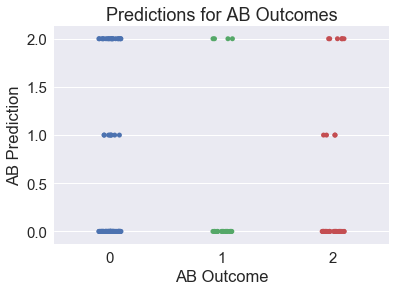

In [284]:
ax = sns.stripplot(x=y_test, y=multi_rf_predict, jitter=True,)
plt.title('Predictions for AB Outcomes')
# Set x-axis label
plt.xlabel('AB Outcome')
# Set y-axis label
plt.ylabel('AB Prediction')


In [285]:
multinomial_report = metrics.classification_report(y_true=y_test, y_pred=multi_rf_predict, labels=None, 
                                                   target_names=['Out', 'Walk', 'Hit'], sample_weight=None, digits=2)
multinomial_report

'             precision    recall  f1-score   support\n\n        Out       0.62      0.76      0.68       116\n       Walk       0.00      0.00      0.00        26\n        Hit       0.20      0.14      0.17        42\n\navg / total       0.44      0.51      0.47       184\n'

In [254]:
roc_curve = metrics.roc_curve(y_true=y_test, y_score=rf_predict_proba[:,1])

roc_auc = metrics.roc_auc_score(y_true=y_test, y_score=rf_predict_proba[:,1])
print(roc_auc)

ValueError: multiclass format is not supported